## Project 2. Part 2 (Explore, Clean & Model)

In [80]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [81]:
import re
import pickle
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
from diagnostic_plots import diagnostic_plots

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.cross_validation import KFold
from sklearn import feature_selection as f_select
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import learning_curve
%matplotlib inline

### Define some useful functions

In [82]:
#To clean the engine_size column (convert into floats)
def clean_engine(series):
    """Takes a series of strings and converts them into floats where possible.
    Returns a list of floats."""
    values = car_ad_dataset['Engine_Size']
    new_values = []
    for value in values:
        try:
            val = float(value)
        except:
            val = np.NaN
        new_values.append(val)
    return new_values

#Clean up the price column
def clean_price(series):
    """Takes a series of strings, cleans them from text and converts them into floats where possible.
    Returns a list of floats."""
    values = series.str.split('€').str[0]
    new_values = []
    for value in values:
        try:
            val = float(re.sub(r'\s+', '', value))
        except:
            val = np.NaN
        new_values.append(val)
    return new_values

#Clean up the mileage column
def clean_kms(series):
    """Takes a series of strings, cleans them from text and converts them into integers where possible.
    Returns a list of integers."""
    values = series.str.split('km').str[0]
    new_values = []
    for value in values:
        try:
            val = int(re.sub(r'\s+', '', value))
        except:
            val = np.NaN
        new_values.append(val)
    return new_values

#Clean up the Number of Doors column
def clean_door_count(series):
    """Takes a series of strings, cleans them from text and converts them into integers where possible.
    Returns a list of integers."""
    values = series.str.split('/').str[0]
    new_values = []
    for value in values:
        try:
            val = int(value)
        except:
            val = np.NaN
        new_values.append(val)
    return new_values

#Convert 'Fuel type' to numeric value (Petrol = 0, Diesel = 1) !If the car is electric, it assigns NaN
def fuel_bool(series):
    """Takes a series with strings and converts them to a boolean representation of 0 for Diesel and 1 for Petrol.
    Returns a list of integers (0, 1)."""
    values = series
    new_values = []
    for value in values:
        if value == 'Petrol' or value == 'Petrol / LPG':
            val = int(1)
            new_values.append(val)
        elif value == 'Diesel' or value == 'Diesel / gas':
            val = int(0)
            new_values.append(val)
        else:
            val = np.NaN
            new_values.append(val)
    return new_values

def gearbox_bool(series):
    """Takes a series with strings and converts them to a boolean representation of 0 for Manual and 1 for Automatic.
    Returns a list of integers (0, 1)."""
    values = series
    new_values = []
    for value in values:
        if value == 'Manual':
            val = int(0)
            new_values.append(val)
        elif value == 'Automatic':
            val = int(1)
            new_values.append(val)
        else:
            val = np.NaN
            new_values.append(val)
    return new_values

def get_white_cars(series):
    """Takes a series with strings and converts them to a boolean representation of 0 for non-White and 1 for White.
    Returns a list of integers (0, 1)."""
    values = series
    new_values = []
    for value in values:
        if value == 'White':
            val = int(1)
            new_values.append(val)
        else:
            val = int(0)
            new_values.append(val)
    return new_values

def get_red_cars(series):
    """Takes a series with strings and converts them to a boolean representation of 0 for non-Red and 1 for Red.
    Returns a list of integers (0, 1)."""
    values = series
    new_values = []
    for value in values:
        if value == 'Red / crimson':
            val = int(1)
            new_values.append(val)
        else:
            val = int(0)
            new_values.append(val)
    return new_values

def group_body_types(series):
    """Takes a series of body types and groups them to categories.
    Returns a list of tuples."""
    body_type_dict = {'Other': ('Other', 'Limousine'), 'Limousine':('Other', 'Limousine'), 'Coupe':('Coupe'), 'Hatchback':('Hatchback'), 'Saloon / sedan':('Saloon / sedan', 'Convertible'), 'Convertible':('Saloon / sedan', 'Convertible'), 'Wagon':('Wagon'), 'SUV / off-road':('SUV / off-road', 'MPV / minivan', 'Commercial', 'Pick-up'), 'MPV / minivan':('SUV / off-road', 'MPV / minivan', 'Commercial', 'Pick-up'), 'Commercial':('SUV / off-road', 'MPV / minivan', 'Commercial', 'Pick-up'), 'Pick-up':('SUV / off-road', 'MPV / minivan', 'Commercial', 'Pick-up')}
    values = series
    new_values = []
    for value in values:
        val = body_type_dict[value]
        new_values.append(val)
    return new_values
    
def numeric_body_type(series):
    """Takes a series of body types and converts them into numbers from smallest to largest.
    Returns a list of integers"""
    body_types = {('Other', 'Limousine'):np.NaN, ('Coupe'):2, ('Hatchback'):3, ('Saloon / sedan', 'Convertible'):4, ('Wagon'):5, ('SUV / off-road', 'MPV / minivan', 'Commercial', 'Pick-up'):6}
    values = series
    new_values = []
    for value in values:
        try:
            val = body_types[value]
            new_values.append(val)
        except:
            val = np.NaN
            new_values.append(val)
    return new_values

def get_german_make(series):
    """Takes a series of car makers and marks as 1 the cars that are German. 
     Returns a list of 1s and 0s."""
    germany = ['BMW', 'Audi', 'Open', 'Mercedes-Benz', 'Porsche', 'Volkswagen', 'Ford']
    values = series
    new_values = []
    for value in values:
        if value in germany:
            new_values.append(1)
        else:
            new_values.append(0)
    return new_values
            
def get_japanese_make(series):
    """Takes a series of car makers and marks as 1 the cars that are Japanese. 
     Returns a list of 1s and 0s."""
    japan = ['Toyota', 'Mazda', 'Honda', 'Nissan', 'Mitsubishi', 'Suzuki', 'Lexus']
    values = series
    new_values = []
    for value in values:
        if value in japan:
            new_values.append(1)
        else:
            new_values.append(0)
    return new_values

def get_french_make(series):
    """Takes a series of car makers and marks as 1 the cars that are French. 
     Returns a list of 1s and 0s."""
    france = ['Renault', 'Citroen', 'Peugeot']
    values = series
    new_values = []
    for value in values:
        if value in france:
            new_values.append(1)
        else:
            new_values.append(0)
    return new_values


# def get_bmw(series):
#     """Takes a series of car makers and marks BMWs as 1, others 0. 
#      Returns a list of 1s and 0s."""
#     values = series
#     new_values = []
#     for value in values:
#         if value == 'BMW':
#             new_values.append(1)
#         else:
#             new_values.append(0)
#     return new_values

# def get_mb(series):
#     """Takes a series of car makers and marks Mercedes-Benz as 1, others 0. 
#      Returns a list of 1s and 0s."""
#     values = series
#     new_values = []
#     for value in values:
#         if value == 'Mercedes-Benz':
#             new_values.append(1)
#         else:
#             new_values.append(0)
#     return new_values

### Unpickle the file

In [83]:
with open('car_ad_dataset.pkl', 'rb') as picklefile:
    car_ad_dataset = pickle.load(picklefile)
    
#Verify that the result is as desired
car_ad_dataset.head()

,Audio/video equipment,Body type,Climate control,Color,Combined,Damage,Date of manufacture,Driven wheels,Electronics,Engine,...,Other features,Price in Lithuania,Safety,Security,Steering wheel,Tuning (improvements),Urban,VIN check,VIN number,Wheel size
0,"CD player,AUX input,Navigation/GPS,Handsfree kit",Wagon,Climate control,Black,NaN,No damages,2018-02,All wheel (4х4),"Electric mirrors,Electric boot lid,Galinio vai...","1995 cm³, 190 HP (139kW)",...,"Not exploited in Lithuania,Available for leasi...",44 900 €,"ABS,Traction control system,ESP iElectronic st...","Central locking,Immobilizer,Alarm",Left hand drive (LHD),NaN,NaN,\n \n Check vehicle history\...,NaN,NaN
1,NaN,Coupe,None,Blue,NaN,No damages,1992,Rear wheel drive (RWD),Electric windows,"1998 cm³, 156 HP (115kW)",...,NaN,4 400 €\n \n Sužinokite įmoką\n ...,NaN,NaN,Left hand drive (LHD),NaN,NaN,\n \n Check vehicle history\...,NaN,R17
2,"CD player,MP3 player,Original audio system,USB...",Hatchback,NaN,NaN,NaN,No damages,2010-03,NaN,Electric windows,"1400 cm³, 89 HP (66kW)",...,Service book,5 500 €\n \n Sužinokite įmoką\n ...,"ABS,EBD iElectronic brakeforce distribution$(""...","Central locking,Alarm",Left hand drive (LHD),NaN,NaN,\n \n Check vehicle history\...,NaN,NaN
3,"CD player,AUX input,Navigation/GPS,USB input,H...",SUV / off-road,NaN,NaN,NaN,No damages,2013-03,NaN,"Electric mirrors,Galinio vaizdo kamera,In-car ...","2200 cm³, 175 HP (129kW)",...,"Not exploited in Lithuania,Available for leasi...",12 700 €\n \n Sužinokite įmoką\n ...,"ABS,EBD iElectronic brakeforce distribution$(""...",NaN,Left hand drive (LHD),NaN,NaN,\n \n Check vehicle history\...,NaN,NaN
4,Navigation/GPS,SUV / off-road,NaN,NaN,NaN,Crashed,2009-03,NaN,"Electric windows,Cruise control",4800 cm³,...,Not exploited in Lithuania,4 999 €\n \n Sužinokite įmoką\n ...,Airbags,NaN,Left hand drive (LHD),NaN,NaN,\n \n Check vehicle history\...,NaN,NaN


In [84]:
#Check out the shape and get info
print('The shape is:', str(car_ad_dataset.shape), '\n');
car_ad_dataset.info()

The shape is: (3020, 35) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3020 entries, 0 to 3019
Data columns (total 35 columns):
Audio/video equipment         995 non-null object
Body type                     1498 non-null object
Climate control               894 non-null object
Color                         1205 non-null object
Combined                      618 non-null object
Damage                        1498 non-null object
Date of manufacture           1498 non-null object
Driven wheels                 1098 non-null object
Electronics                   1243 non-null object
Engine                        1475 non-null object
Engine_Size                   1498 non-null object
Euro standard                 475 non-null object
Export price                  376 non-null object
Exterior                      1218 non-null object
Extra-urban                   617 non-null object
First registration country    703 non-null object
Fuel type                     1498 non-null object
Gearbo

In [85]:
#Explore the dataset
car_ad_dataset.count().sort_values(ascending = False)

Gearbox                       1498
Price in Lithuania            1498
Fuel type                     1498
Make_Model                    1498
Number of doors               1498
Date of manufacture           1498
Engine_Size                   1498
Damage                        1498
Steering wheel                1498
Body type                     1498
VIN check                     1493
Engine                        1475
Interior                      1258
Electronics                   1243
Exterior                      1218
Color                         1205
Mileage                       1157
Safety                        1146
Driven wheels                 1098
Number of seats               1036
Audio/video equipment          995
Other features                 909
Security                       907
Climate control                894
Wheel size                     782
MOT test expiry                773
First registration country     703
Combined                       618
Extra-urban         

### Clean the dataset

**Initial cleaning and formatting**

In [86]:
#Check out the records without mileage 
#car_ad_dataset.iloc[28]
#Conclusion: they are indeed legit

In [87]:
#Clean up the price column and convert to a float
car_ad_dataset['Price'] = clean_price(car_ad_dataset['Price in Lithuania'])

In [88]:
#Split the Make_Model column
car_ad_dataset['Make'], car_ad_dataset['Model'] = car_ad_dataset['Make_Model'].str.split(' ', 1).str

In [89]:
#Group Makes into countries
car_ad_dataset['Is_German'] = get_german_make(car_ad_dataset['Make'])

car_ad_dataset['Is_French'] = get_french_make(car_ad_dataset['Make'])

car_ad_dataset['Is_Japanese'] = get_japanese_make(car_ad_dataset['Make'])

# car_ad_dataset['Is_BMW'] = get_bmw(car_ad_dataset['Make'])

# car_ad_dataset['Is_Mercedes_Benz'] = get_mb(car_ad_dataset['Make'])

In [90]:
#Clean up the Engine_Size column from l.
car_ad_dataset['Engine_Size'] = car_ad_dataset['Engine_Size'].str.split(' ', 2).str[1]
car_ad_dataset['Engine_Size_l'] = clean_engine(car_ad_dataset['Engine_Size'])

In [91]:
#Clean the Engine column
#Some of the cars don't have the cm3, so instead this takes HP or kW, will have to drop those later on!!!
#car_ad_dataset['Engine_cm3'] = pd.to_numeric(car_ad_dataset['Engine'].str.split(' ').str[0])

In [92]:
#Only keep the Year of manufacture
car_ad_dataset['Year_of_manufacture'] = pd.to_numeric(car_ad_dataset['Date of manufacture'].str[:4])

In [93]:
#Clean up the milage column to remove 'km'
car_ad_dataset['Mileage_km'] = clean_kms(car_ad_dataset['Mileage'])

In [94]:
#Clean up the number of doors to remove /second number
car_ad_dataset['Door_count'] = clean_door_count(car_ad_dataset['Number of doors'])

In [95]:
#Convert Fuel type column to boolean (0,1)
car_ad_dataset['Fuel type'] = fuel_bool(car_ad_dataset['Fuel type'])

In [96]:
car_ad_dataset['Gearbox'] = gearbox_bool(car_ad_dataset['Gearbox'])
#car_ad_dataset['Gearbox']

In [97]:
car_ad_dataset['Is_White'] = get_white_cars(car_ad_dataset['Color'])
#car_ad_dataset['Is_White']

In [98]:
car_ad_dataset['Is_Red'] = get_red_cars(car_ad_dataset['Color'])
#car_ad_dataset['Is_Red']

In [99]:
#Rename the Fuel type column
car_ad_dataset = car_ad_dataset.rename(columns = {'Fuel type': 'Fuel_type'})

In [100]:
#Remove cars that are damaged
car_ad_dataset = car_ad_dataset[car_ad_dataset['Damage'] == 'No damages']
car_ad_dataset.drop(columns = ['Damage'], inplace = True)

#Remove cars that are not Left hand drive
car_ad_dataset = car_ad_dataset[car_ad_dataset['Steering wheel'] == 'Left hand drive (LHD)']
car_ad_dataset.drop(columns = ['Steering wheel'], inplace = True)

#car_ad_dataset.head()

In [101]:
#Generalize body types
car_ad_dataset['Body_type_group'] = group_body_types(car_ad_dataset['Body type'])
car_ad_dataset['Body_type'] = numeric_body_type(car_ad_dataset['Body_type_group'])

In [102]:
#car_ad_dataset['Make'].value_counts()

In [103]:
#car_ad_dataset['Color'].value_counts()

In [104]:
#Let's have a look
car_ad_dataset.count().sort_values(ascending = False)

Gearbox                       1376
Price in Lithuania            1376
Date of manufacture           1376
Number of doors               1376
Body type                     1376
Price                         1376
Make                          1376
Model                         1376
Is_German                     1376
Is_French                     1376
Is_Japanese                   1376
Make_Model                    1376
Year_of_manufacture           1376
Engine_Size                   1376
Is_White                      1376
Is_Red                        1376
Body_type_group               1376
VIN check                     1371
Door_count                    1369
Body_type                     1364
Engine                        1357
Fuel_type                     1356
Engine_Size_l                 1329
Interior                      1185
Electronics                   1170
Exterior                      1151
Color                         1118
Safety                        1083
Mileage             

**Shorten the dataset & re-evaluate**

In [105]:
#Shorten the dataset by picking the most logical features
short_car_ad_dataset = car_ad_dataset[['Price', 'Year_of_manufacture', 'Engine_Size_l', 'Gearbox', 'Mileage_km', 'Body_type', 'Door_count', 'Fuel_type', 'Is_White', 'Is_Red', 'Is_German', 'Is_Japanese', 'Is_French']]
short_car_ad_dataset.head()

,Price,Year_of_manufacture,Engine_Size_l,Gearbox,Mileage_km,Body_type,Door_count,Fuel_type,Is_White,Is_Red,Is_German,Is_Japanese,Is_French
0,44900.0,2018.0,2.0,1.0,8100.0,5.0,4.0,0.0,0,0,1,0,0
1,4400.0,1992.0,2.0,0.0,270000.0,2.0,2.0,1.0,0,0,0,1,0
2,5500.0,2010.0,1.4,0.0,161800.0,3.0,4.0,0.0,0,0,0,1,0
3,12700.0,2013.0,2.2,1.0,208000.0,6.0,4.0,0.0,0,0,0,1,0
6,4999.0,2009.0,2.5,1.0,144000.0,4.0,4.0,1.0,0,0,0,1,0


In [106]:
#Get the info on the shorten dataset
short_car_ad_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1376 entries, 0 to 2987
Data columns (total 13 columns):
Price                  1376 non-null float64
Year_of_manufacture    1376 non-null float64
Engine_Size_l          1329 non-null float64
Gearbox                1376 non-null float64
Mileage_km             1070 non-null float64
Body_type              1364 non-null float64
Door_count             1369 non-null float64
Fuel_type              1356 non-null float64
Is_White               1376 non-null int64
Is_Red                 1376 non-null int64
Is_German              1376 non-null int64
Is_Japanese            1376 non-null int64
Is_French              1376 non-null int64
dtypes: float64(8), int64(5)
memory usage: 150.5 KB


**Clean the small dataset of NaN values**

In [107]:
#Drop all the cars that are missing at least one of the values
clean_car_ad_dataset = short_car_ad_dataset.dropna(how = 'any')

#And review again
clean_car_ad_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1015 entries, 0 to 2987
Data columns (total 13 columns):
Price                  1015 non-null float64
Year_of_manufacture    1015 non-null float64
Engine_Size_l          1015 non-null float64
Gearbox                1015 non-null float64
Mileage_km             1015 non-null float64
Body_type              1015 non-null float64
Door_count             1015 non-null float64
Fuel_type              1015 non-null float64
Is_White               1015 non-null int64
Is_Red                 1015 non-null int64
Is_German              1015 non-null int64
Is_Japanese            1015 non-null int64
Is_French              1015 non-null int64
dtypes: float64(8), int64(5)
memory usage: 111.0 KB


In [108]:
#Let's have a look again
clean_car_ad_dataset.head()

,Price,Year_of_manufacture,Engine_Size_l,Gearbox,Mileage_km,Body_type,Door_count,Fuel_type,Is_White,Is_Red,Is_German,Is_Japanese,Is_French
0,44900.0,2018.0,2.0,1.0,8100.0,5.0,4.0,0.0,0,0,1,0,0
1,4400.0,1992.0,2.0,0.0,270000.0,2.0,2.0,1.0,0,0,0,1,0
2,5500.0,2010.0,1.4,0.0,161800.0,3.0,4.0,0.0,0,0,0,1,0
3,12700.0,2013.0,2.2,1.0,208000.0,6.0,4.0,0.0,0,0,0,1,0
6,4999.0,2009.0,2.5,1.0,144000.0,4.0,4.0,1.0,0,0,0,1,0


**Explore target variable**

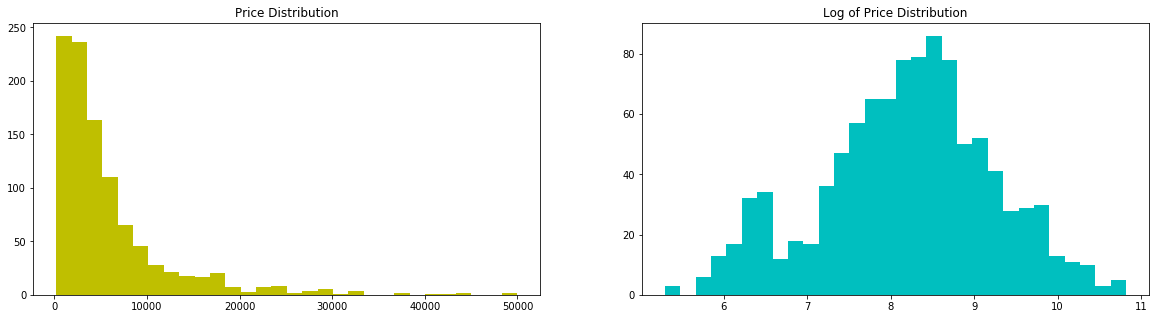

In [109]:
#Plot Price histogram (to check the distribution)
fig = plt.figure(figsize = (20, 5))
plt.subplot(1, 2, 1)
plt.hist(clean_car_ad_dataset['Price'], bins=30, color = 'y')
plt.title('Price Distribution')

plt.subplot(1, 2, 2)
plt.hist(np.log(clean_car_ad_dataset['Price']), bins=30, color = 'c')
plt.title('Log of Price Distribution')
plt.show()

In [110]:
#Let's find the minimum and maximum prices
print(clean_car_ad_dataset['Price'].min())
print(clean_car_ad_dataset['Price'].max())

200.0
50000.0


In [111]:
#What is a reasonable lower threshold to set for the price?
clean_car_ad_dataset[(clean_car_ad_dataset['Price'] <= 200.0) | (clean_car_ad_dataset['Price'] >= 40000)]

,Price,Year_of_manufacture,Engine_Size_l,Gearbox,Mileage_km,Body_type,Door_count,Fuel_type,Is_White,Is_Red,Is_German,Is_Japanese,Is_French
0,44900.0,2018.0,2.0,1.0,8100.0,5.0,4.0,0.0,0,0,1,0,0
108,200.0,1997.0,1.8,0.0,130000.0,3.0,4.0,1.0,0,0,0,0,1
980,41000.0,2016.0,3.6,1.0,60200.0,6.0,4.0,1.0,1,0,1,0,0
982,42500.0,2017.0,2.0,1.0,10900.0,6.0,4.0,1.0,0,0,1,0,0
983,43900.0,2015.0,3.0,1.0,79700.0,6.0,4.0,0.0,0,0,1,0,0
2344,49900.0,2015.0,3.0,1.0,39100.0,4.0,4.0,0.0,0,0,1,0,0
2345,50000.0,2015.0,3.0,1.0,80000.0,6.0,4.0,0.0,0,0,1,0,0
2361,200.0,1990.0,1.3,0.0,43000.0,4.0,4.0,1.0,0,0,0,0,0


In [112]:
#Choosing the lower bound to be €200 (not incl.) and upper bound €40k (incl.)
clean_car_ad_dataset = clean_car_ad_dataset[(clean_car_ad_dataset['Price'] > 200.0) & (clean_car_ad_dataset['Price'] <= 40000.0)]
#clean_car_ad_dataset.head()

In [113]:
print('The average car price is €', str(round(clean_car_ad_dataset['Price'].mean(), 0)))
print('The median car price is €', str(round(clean_car_ad_dataset['Price'].median(), 0)))

The average car price is € 5674.0
The median car price is € 3900.0


**Explore the features**

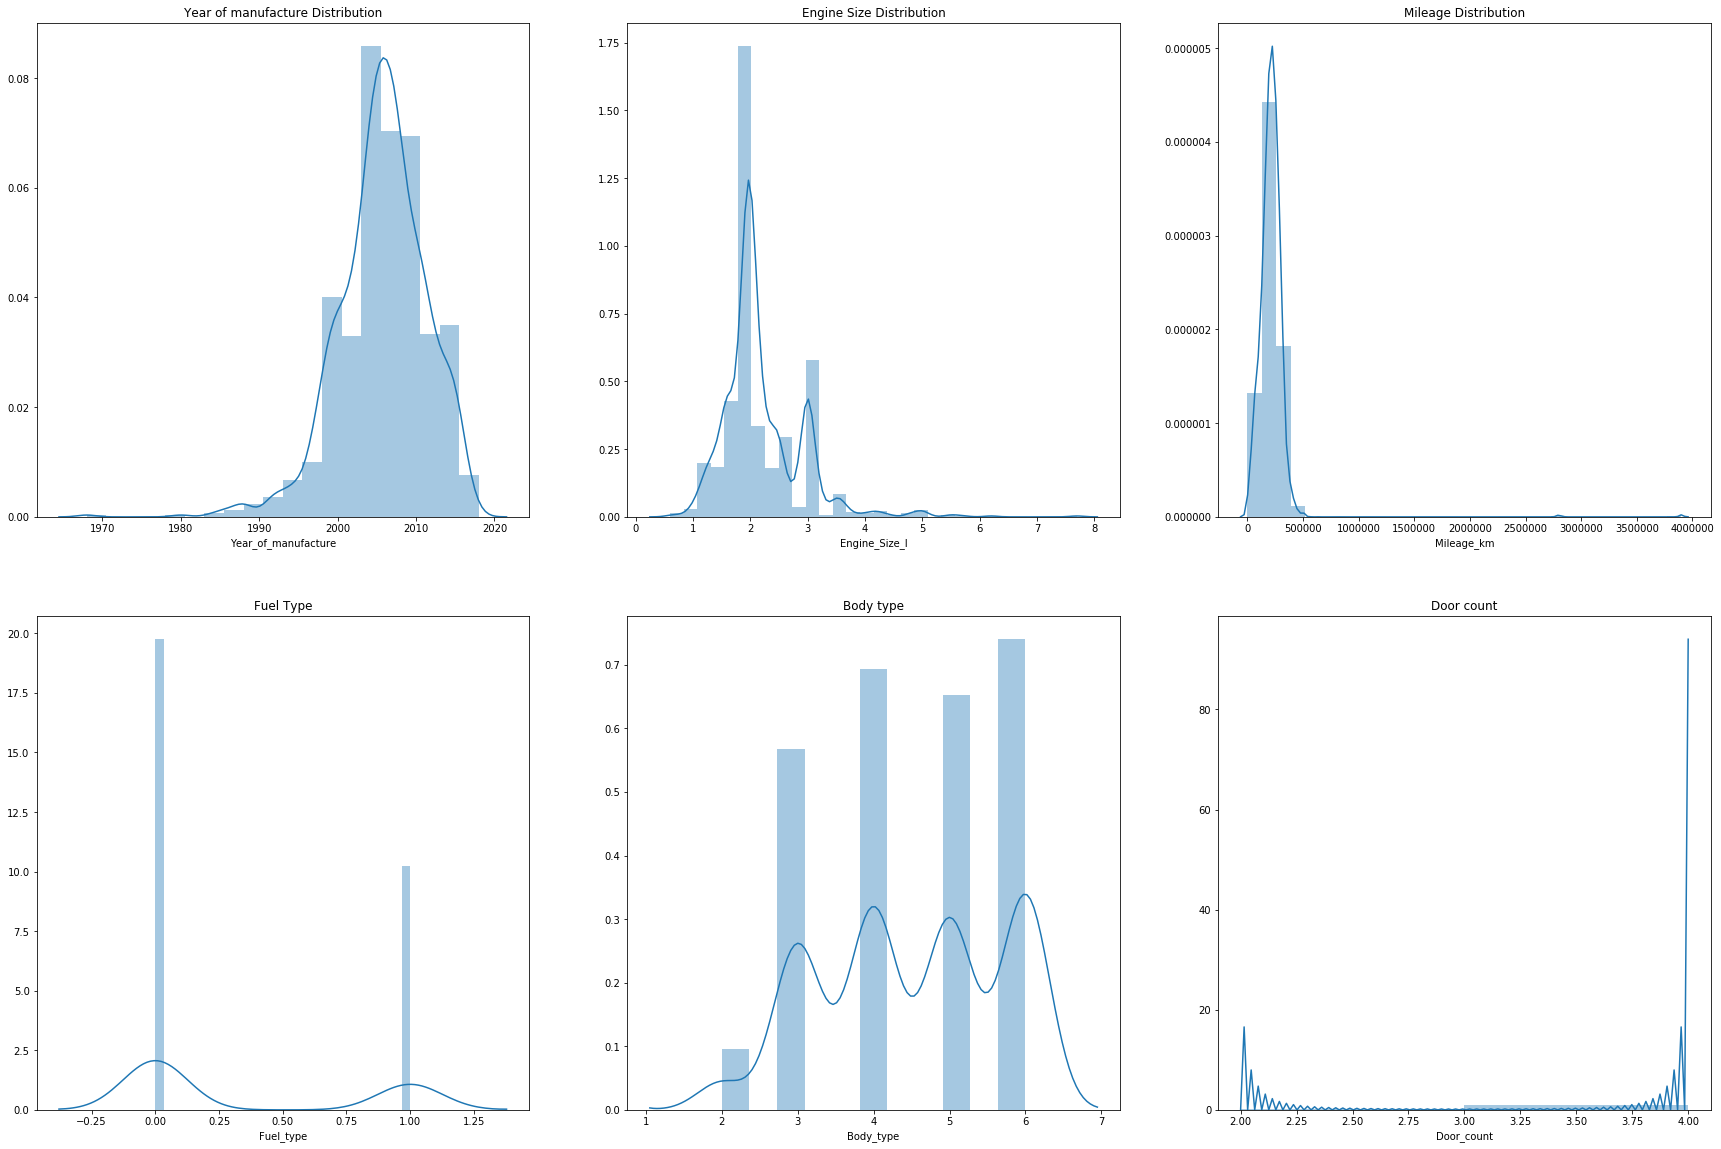

In [114]:
#Create a 2 x 3 plot matrix
fig = plt.figure(figsize = (30, 20))

#Distribution of years
plt.subplot(2, 3, 1)
sns.distplot(clean_car_ad_dataset["Year_of_manufacture"], bins = 20); 
plt.title('Year of manufacture Distribution')

#Distribution of Engine Size 
plt.subplot(2, 3, 2)
sns.distplot(clean_car_ad_dataset["Engine_Size_l"], bins = 30); 
plt.title('Engine Size Distribution')

#Distribution of Mileage 
plt.subplot(2, 3, 3)
sns.distplot(clean_car_ad_dataset["Mileage_km"], bins = 30); 
plt.title('Mileage Distribution')

#Distribution of Fuel Type
plt.subplot(2, 3, 4)
sns.distplot(clean_car_ad_dataset["Fuel_type"], bins = 30); 
plt.title('Fuel Type')

#Distribution of Body Type
plt.subplot(2, 3, 5)
sns.distplot(clean_car_ad_dataset["Body_type"]); 
plt.title('Body type')

#Distribution of Door count
plt.subplot(2, 3, 6)
sns.distplot(clean_car_ad_dataset["Door_count"], bins = 2); 
plt.title('Door count');


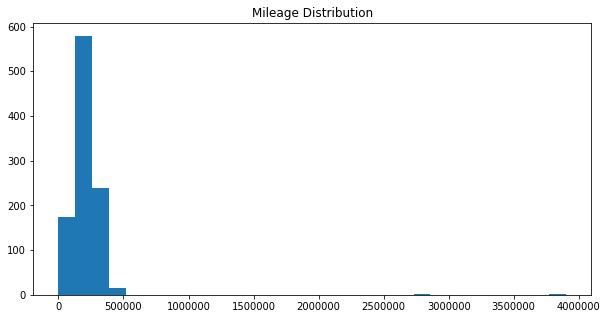

In [115]:
#Plot Mileage histogram (to check the distribution)
plt.figure(figsize = (10, 5))
plt.hist(clean_car_ad_dataset['Mileage_km'], bins=30)
plt.title('Mileage Distribution');


In [116]:
#Check Mileage outliers
#clean_car_ad_dataset[(clean_car_ad_dataset['Mileage_km'] >= 450000.0) | (clean_car_ad_dataset['Mileage_km'] == 0.0)]
clean_car_ad_dataset = clean_car_ad_dataset[(clean_car_ad_dataset['Mileage_km'] > 0.0) & (clean_car_ad_dataset['Mileage_km'] <= 450000.0)]
#clean_car_ad_dataset.head()

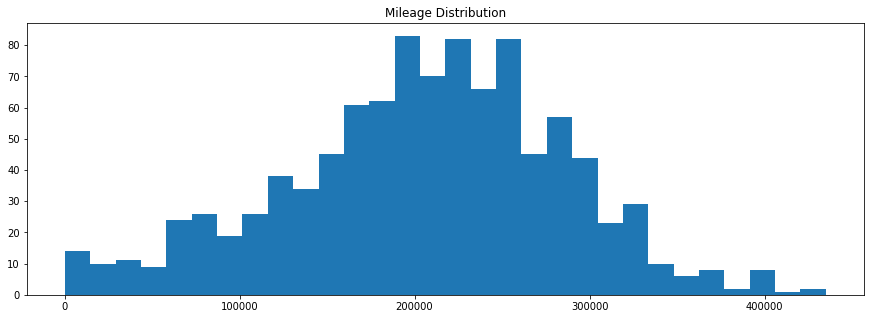

In [117]:
#Let's plot Mileage histogram again, after removing outliers (to check the distribution)
plt.figure(figsize = (15, 5))
plt.hist(clean_car_ad_dataset['Mileage_km'], bins=30)
plt.title('Mileage Distribution');

**Let's look at those massive engines**

In [118]:
#Checked Engine Size outliers
#clean_car_ad_dataset[clean_car_ad_dataset['Engine_Size_l'] >= 5.0]
#clean_car_ad_dataset['Engine_Size_l'].value_counts()
#clean_car_ad_dataset = clean_car_ad_dataset[clean_car_ad_dataset['Engine_Size_l'] <= 5.0]
#clean_car_ad_dataset.head()

**Removing very old & newcars (year of manufacture before 1990 and after 2016)**

In [119]:
#Checked Year_of_manufacture outliers
#clean_car_ad_dataset[clean_car_ad_dataset['Year_of_manufacture'] <= 1990.0]
clean_car_ad_dataset = clean_car_ad_dataset[(clean_car_ad_dataset['Year_of_manufacture'] >= 1995.0) & (clean_car_ad_dataset['Year_of_manufacture'] < 2017.0)]
#clean_car_ad_dataset.head()

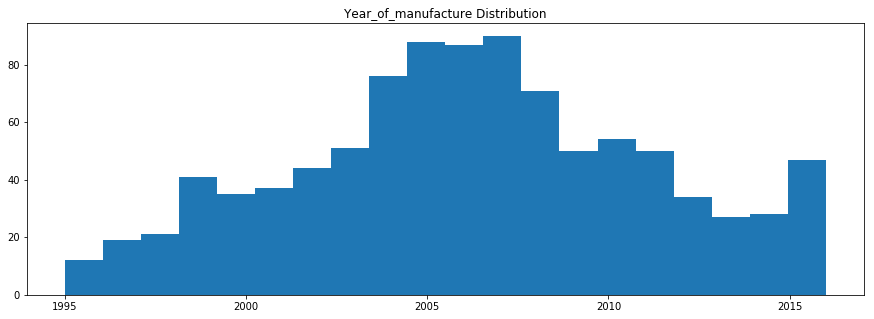

In [120]:
#Let's plot Year_of_manufacture histogram again, after removing outliers (to check the distribution)
plt.figure(figsize = (15, 5))
plt.hist(clean_car_ad_dataset['Year_of_manufacture'], bins=20)
plt.title('Year_of_manufacture Distribution');

**Let's re-assess a after cleanup**

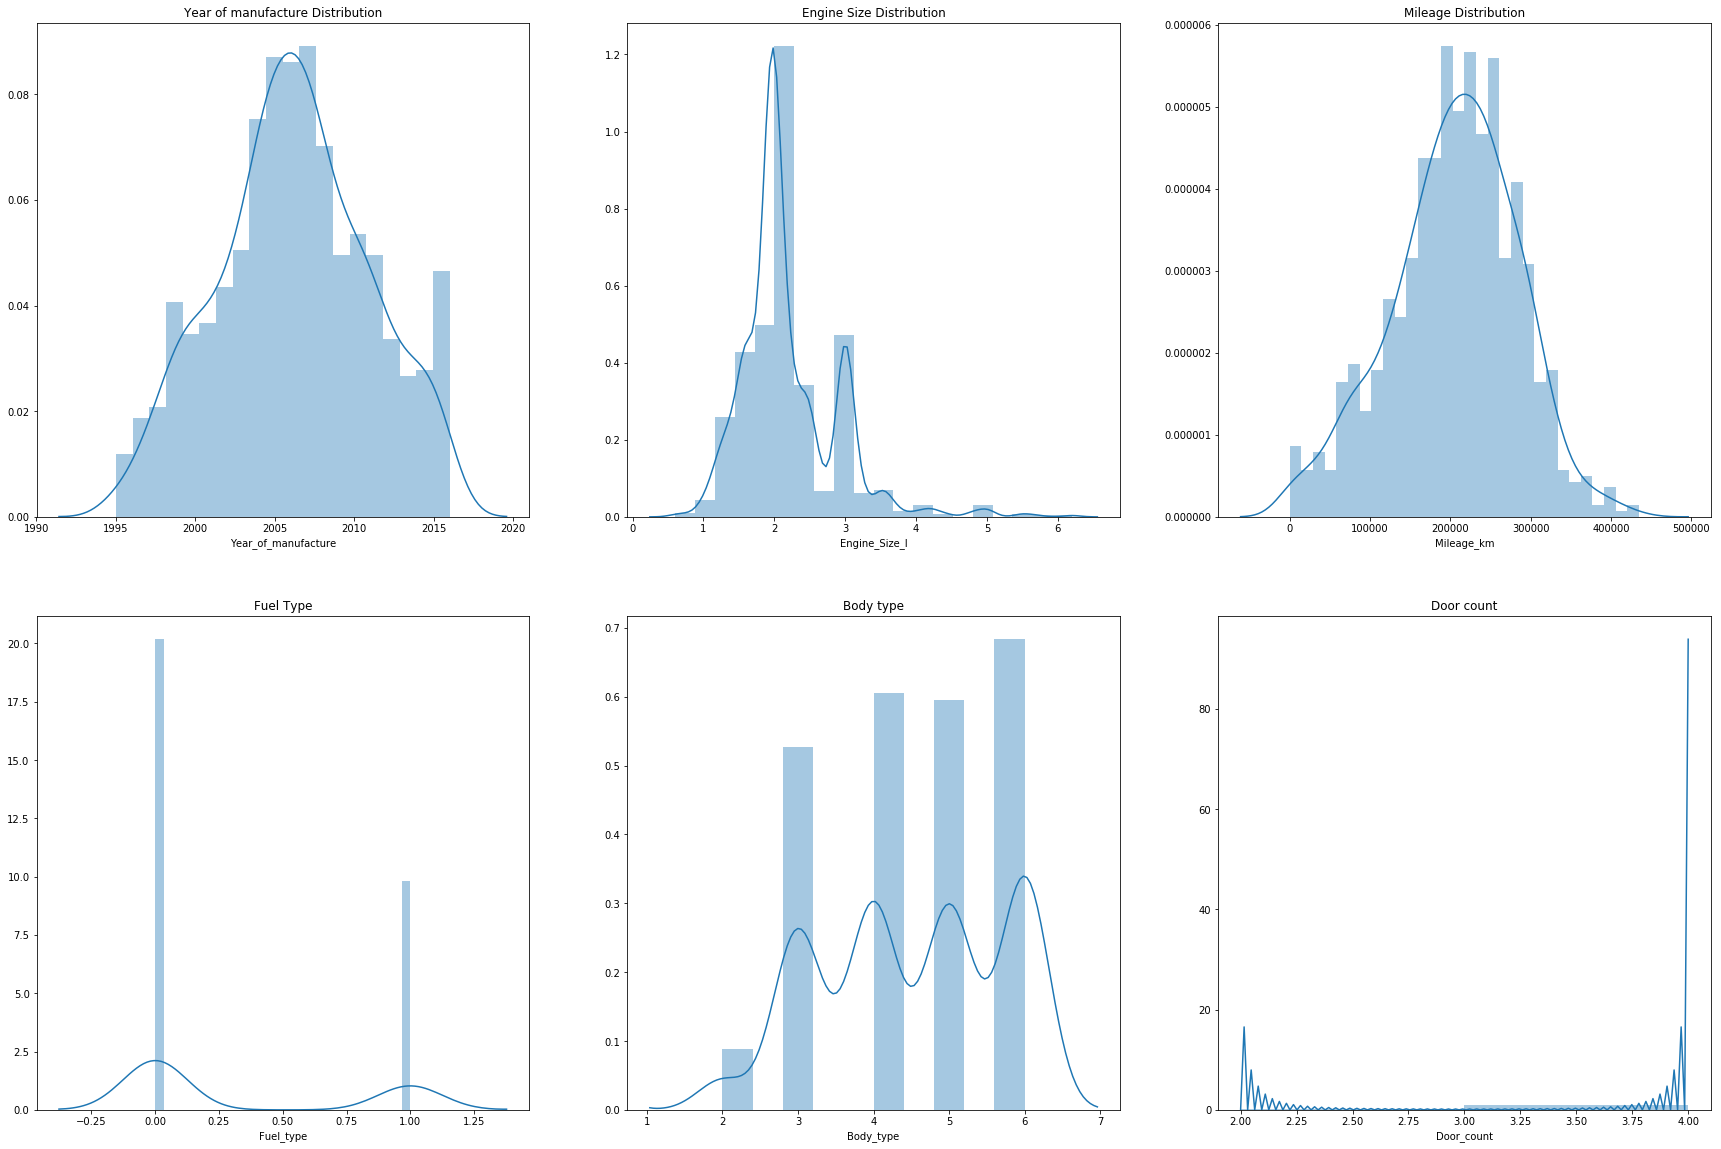

In [121]:
#Create a 2 x 3 plot matrix
fig = plt.figure(figsize = (30, 20))

#Distribution of years
plt.subplot(2, 3, 1)
sns.distplot(clean_car_ad_dataset["Year_of_manufacture"], bins = 20); 
plt.title('Year of manufacture Distribution')

#Distribution of Engine Size 
plt.subplot(2, 3, 2)
sns.distplot(clean_car_ad_dataset["Engine_Size_l"], bins = 20); 
plt.title('Engine Size Distribution')

#Distribution of Mileage 
plt.subplot(2, 3, 3)
sns.distplot(clean_car_ad_dataset["Mileage_km"], bins = 30); 
plt.title('Mileage Distribution')

#Distribution of Fuel Type
plt.subplot(2, 3, 4)
sns.distplot(clean_car_ad_dataset["Fuel_type"], bins = 30); 
plt.title('Fuel Type')

#Distribution of Body Type
plt.subplot(2, 3, 5)
sns.distplot(clean_car_ad_dataset["Body_type"]); 
plt.title('Body type')

#Distribution of Door count
plt.subplot(2, 3, 6)
sns.distplot(clean_car_ad_dataset["Door_count"], bins = 2); 
plt.title('Door count');


### More analysis

In [122]:
#Check the correlation between different variables
car_subset1 = clean_car_ad_dataset[['Price', 'Year_of_manufacture', 'Engine_Size_l', 'Gearbox', 'Mileage_km']]
car_subset1.corr()

,Price,Year_of_manufacture,Engine_Size_l,Gearbox,Mileage_km
Price,1.000000,0.703904,0.365743,0.475424,-0.443935
Year_of_manufacture,0.703904,1.000000,0.032849,0.295367,-0.488564
Engine_Size_l,0.365743,0.032849,1.000000,0.527768,0.058759
Gearbox,0.475424,0.295367,0.527768,1.000000,-0.146918
Mileage_km,-0.443935,-0.488564,0.058759,-0.146918,1.000000


In [123]:
#Check the correlation between different variables
car_subset2 = clean_car_ad_dataset[['Price', 'Body_type', 'Is_White', 'Is_Red', 'Is_German', 'Is_Japanese', 'Is_French']]
car_subset2.corr()

,Price,Body_type,Is_White,Is_Red,Is_German,Is_Japanese,Is_French
Price,1.000000,0.111729,0.164969,-0.049653,0.212688,-0.055714,-0.124420
Body_type,0.111729,1.000000,0.039500,-0.127571,-0.085156,0.037206,0.057651
Is_White,0.164969,0.039500,1.000000,-0.048484,-0.020227,-0.012564,0.039701
Is_Red,-0.049653,-0.127571,-0.048484,1.000000,-0.090346,-0.004678,0.113749
Is_German,0.212688,-0.085156,-0.020227,-0.090346,1.000000,-0.405469,-0.301216
Is_Japanese,-0.055714,0.037206,-0.012564,-0.004678,-0.405469,1.000000,-0.137232
Is_French,-0.124420,0.057651,0.039701,0.113749,-0.301216,-0.137232,1.000000


In [124]:
#Check the correlation between different variables
car_subset2 = clean_car_ad_dataset[['Price', 'Year_of_manufacture', 'Engine_Size_l', 'Gearbox', 'Mileage_km', 'Body_type', 'Is_White', 'Is_Red', 'Is_German', 'Is_Japanese', 'Is_French']]
car_subset2.corr()

,Price,Year_of_manufacture,Engine_Size_l,Gearbox,Mileage_km,Body_type,Is_White,Is_Red,Is_German,Is_Japanese,Is_French
Price,1.000000,0.703904,0.365743,0.475424,-0.443935,0.111729,0.164969,-0.049653,0.212688,-0.055714,-0.124420
Year_of_manufacture,0.703904,1.000000,0.032849,0.295367,-0.488564,0.131869,0.206858,-0.030559,-0.056267,0.014711,-0.002376
Engine_Size_l,0.365743,0.032849,1.000000,0.527768,0.058759,0.185028,0.011817,-0.104099,0.318444,-0.079531,-0.198364
Gearbox,0.475424,0.295367,0.527768,1.000000,-0.146918,0.108727,0.042678,-0.064429,0.266536,-0.152239,-0.107043
Mileage_km,-0.443935,-0.488564,0.058759,-0.146918,1.000000,0.117400,-0.140883,-0.104207,0.115613,-0.050180,-0.038950
Body_type,0.111729,0.131869,0.185028,0.108727,0.117400,1.000000,0.039500,-0.127571,-0.085156,0.037206,0.057651
Is_White,0.164969,0.206858,0.011817,0.042678,-0.140883,0.039500,1.000000,-0.048484,-0.020227,-0.012564,0.039701
Is_Red,-0.049653,-0.030559,-0.104099,-0.064429,-0.104207,-0.127571,-0.048484,1.000000,-0.090346,-0.004678,0.113749
Is_German,0.212688,-0.056267,0.318444,0.266536,0.115613,-0.085156,-0.020227,-0.090346,1.000000,-0.405469,-0.301216
Is_Japanese,-0.055714,0.014711,-0.079531,-0.152239,-0.050180,0.037206,-0.012564,-0.004678,-0.405469,1.000000,-0.137232


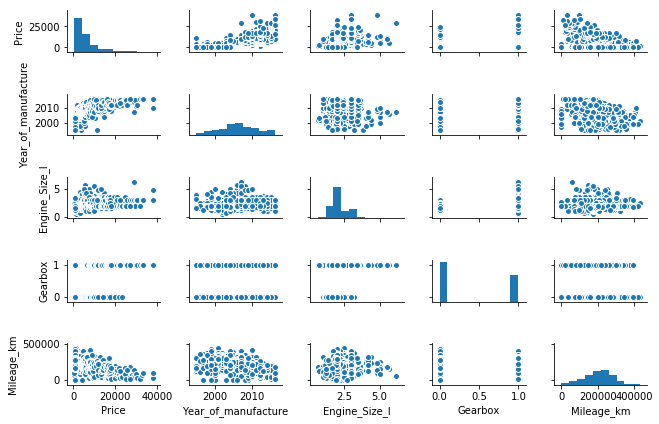

In [125]:
#Visualize the correlations of subset1
sns.pairplot(car_subset1, size = 1.2, aspect=1.5);

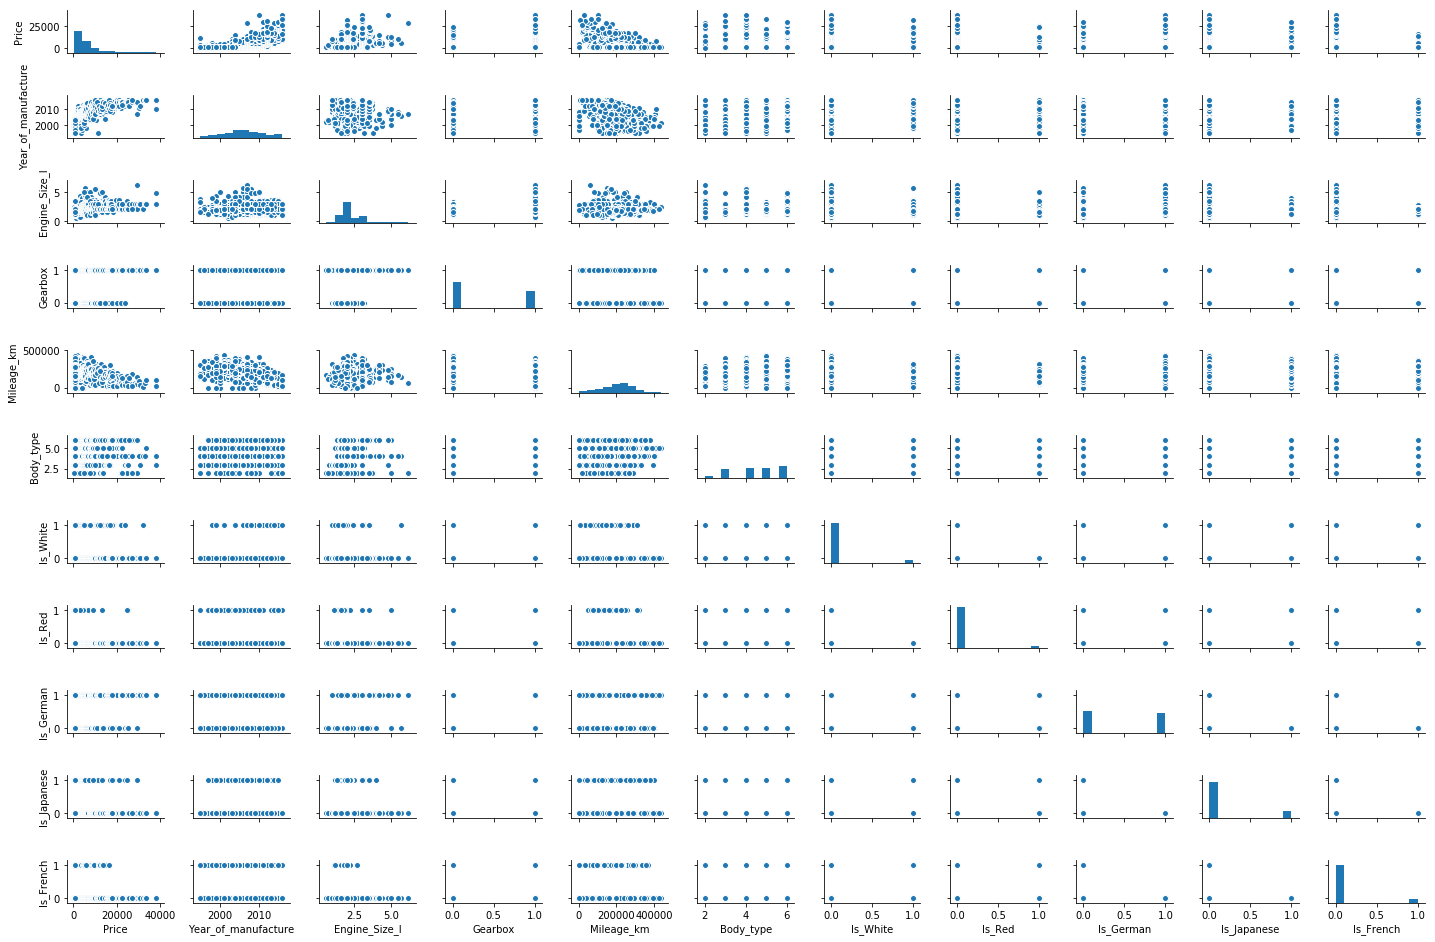

In [126]:
#Visualize the correlations of subset2
sns.pairplot(car_subset2, size = 1.2, aspect=1.5);

## Let's try modelling

### Statsmodels way (with log price)

In [127]:
# #Create the target vector and feature matrix
m, K = patsy.dmatrices('np.log(Price) ~ Year_of_manufacture + Mileage_km + Engine_Size_l + Gearbox + Is_Japanese + Is_French + Is_German', clean_car_ad_dataset)

#Linear Regression
car_ad_model_sms = sm.OLS(m, K)
car_ad_model_sms_fit = car_ad_model_sms.fit()
car_ad_model_sms_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          np.log(Price)   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.842
Method:                 Least Squares   F-statistic:                     731.4
Date:                Thu, 19 Jul 2018   Prob (F-statistic):               0.00
Time:                        18:05:57   Log-Likelihood:                -436.02
No. Observations:                 962   AIC:                             888.0
Df Residuals:                     954   BIC:                             927.0
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept            -310.7312      6.294    -49.369      0.000    -323.083    -298.379
Year_of_manufacture     0.1585      0.003     50.670      0.000       0.152       0.165
Mileage_km          -3.732e-07   1.82e-07     -2.056      0.040   -7.29e-07   -1.69e-08
Engine_Size_l           0.3761      0.022     16.891      0.000       0.332       0.420
Gearbox                 0.1687      0.032      5.280      0.000       0.106       0.231
Is_Japanese             0.1458      0.039      3.730      0.000       0.069       0.223
Is_French              -0.2491      0.047     -5.302      0.000      -0.341      -0.157
Is_German               0.3014      0.031      9.810      0.000       0.241       0.362
==============================================================================
Omnibus:                       51.886   Durbin-Watson:                   1.591
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              176.330
Skew:                          -0.099   Prob(JB):                     5.13e-39
Kurtosis:                       5.088   Cond. No.                     1.12e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.12e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

> Results with just Year_of_manufacture: adj.R2 = 0.676, F-stat = 2070, Log-like = -860, Cond.No = 7.91e+05   
Results with just Year_of_manufacture and Engine Size: adj.R2 = 0.801, F-stat = 2002, Log-like = -616, Cond.No = 7.92e+05   
Results with just Year_of_manufacture, Engine Size and Mileage: adj.R2 = 0.801, F-stat = 1335, Log-like = -616, Cond.No. = 9.99e+07   
Results with just Year_of_manufac, Engine Size, Mileage and Fuel type: adj.R2 = 0.802, F-stat = 1007, Log-like = -613, Cond.No = 1.05e+08   
Results with just Year_of_manufac, Engine Size, Mileage, Fuel type and Gearbox: adj.R2 = 0.810, F-stat = 850, Log-like = -592, Cond. No = 1.10e+08   
Results with just Year_of_manufac, Engine Size, Mileage, Fuel type, Gearbox and Is_German: adj.R2 = 0.830, F-stat = 808, Log-like = -537, Cond.No = 1.10e+08   
Results with just Year_of_manufac, Engine Size, Mileage, Fuel type, Gearbox, Is_German and Is_French: adj.R2 = 0.837, F-stat = 727, Log-like = -516, Cond.No = 1.11e+08   
Results with just Year_of_manufac, Engine Size, Mileage, Fuel type, Gearbox, Is_German, Is_French and Is_Japanese: adj.R2 = 0.840, F-stat = 651, Log-like = -507, Cond.No = 1.11e+08

-1.666614959273165

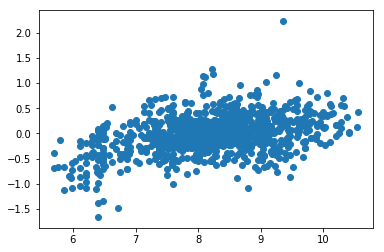

In [128]:
# Use statsmodels to plot the residuals# Use s 
residuals_sms = car_ad_model_sms_fit.resid
plt.scatter(m, residuals_sms)
residuals_sms.min()

In [129]:
#What's this really large residual?
#min_index = np.argmin(residuals_sms)
#clean_car_ad_dataset.iloc[min_index]

In [130]:
#Let's check this records out
#clean_car_ad_dataset[clean_car_ad_dataset['Price'] == 3.0]
#Seems very unlikely that this car costs only €3

### Sklearn way

**Training and testing**

In [131]:
X_all, y_all = clean_car_ad_dataset[['Year_of_manufacture', 'Engine_Size_l', 'Mileage_km', 'Fuel_type', 'Gearbox',
                                     'Is_German', 'Is_French', 'Is_Japanese']], clean_car_ad_dataset['Price']

In [132]:
#Split the data into train and test datasets
X_all_train, X_all_test, y_all_train, y_all_test = train_test_split(X_all, y_all, test_size = 0.3, random_state = 42)

### Explore model options

**No regularization - simple Linear Regression**

In [133]:
#Create a linear regression model
car_ad_model = LinearRegression()

#Fit the model with train values
car_ad_model_fit = car_ad_model.fit(X_all_train, y_all_train)

**Let's try to predict y_values, based on the current model and x_values**

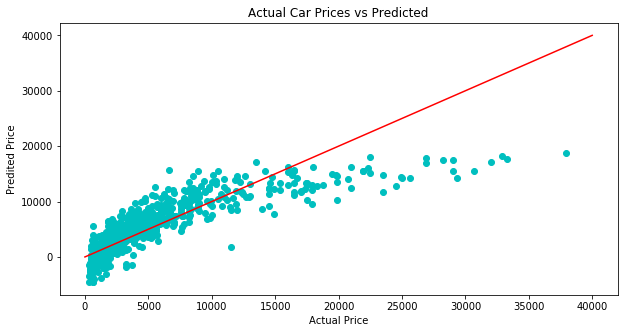

In [134]:
#Let's plot predicted versus actual (from training data)
y_all_predicted = car_ad_model.predict(X_all_train)

plt.figure(figsize=(10, 5))
plt.scatter(y_all_train, y_all_predicted, color = 'c')
plt.plot([0, 40000], [0, 40000], color='r')
plt.title('Actual Car Prices vs Predicted')
plt.xlabel('Actual Price')
plt.ylabel('Predited Price')
plt.show()

#Definitely a non-linear pattern there - UPS! Looks kinda logistic

In [135]:
#Let's look at the coefficients of my model
print(pd.Series(car_ad_model_fit.coef_, X_all_train.columns))

Year_of_manufacture     745.527784
Engine_Size_l          1840.662849
Mileage_km               -0.012980
Fuel_type               170.284617
Gearbox                1240.746392
Is_German              2011.600630
Is_French              -411.511689
Is_Japanese             323.916359
dtype: float64


In [136]:
#Let's do some cross-validation
scores_r2 = cross_val_score(car_ad_model, X_all_train, y_all_train, cv = 5, scoring='r2')
print('The r-squared scores of cross validation:', str(scores_r2))
print('The mean of r-squared scores is', str(round(scores_r2.mean(), 3))+ '.\n')

scores_mse = cross_val_score(car_ad_model, X_all_train, y_all_train, cv = 5, scoring='neg_mean_squared_error')
print('The mean squared error scores of cross validation:', str(-scores_mse))
print('The mean of the mean squared error scores is:', str(round(-scores_mse.mean(), 3)), '\n')
print("On average, I'm missing the price by €"+ str(round(np.sqrt(-scores_mse.mean()), 2)))


The r-squared scores of cross validation: [0.69856883 0.62924792 0.71410272 0.67302245 0.61013591]
The mean of r-squared scores is 0.665.

The mean squared error scores of cross validation: [12278146.48633577 13414898.24402506  9709213.97360978  9472501.72897935
 11284641.13049955]
The mean of the mean squared error scores is: 11231880.313 

On average, I'm missing the price by €3351.4


> **Niet Goed!**

**Adjusted R-squared calculation**

In [137]:
adj_r2_list = []
for score in scores_r2:
    adjusted_r2 = 1 - (1 - score) * (len(y_all_train)-1) / (len(y_all_train) - X_all_train.shape[1] -1)
    adj_r2_list.append(adjusted_r2)
    
print('Average adj. r-squared is:', str(np.array(adj_r2_list).mean()))

Average adj. r-squared is: 0.6609796093569489


**Let's examine the residuals, shall we?**

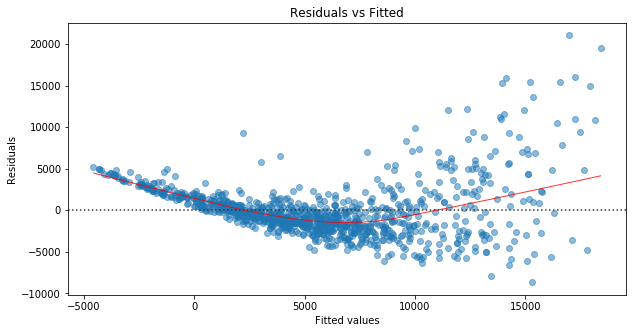

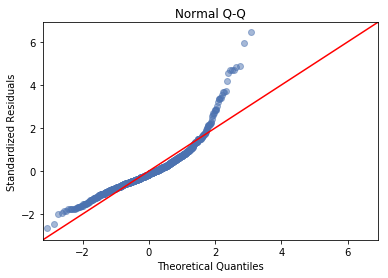

In [138]:
# Use diagnostic_plots python file to plot Year of manufacture results
diagnostic_plots(clean_car_ad_dataset[['Year_of_manufacture', 'Engine_Size_l', 'Mileage_km', 'Fuel_type', 'Gearbox',
                                       'Is_German', 'Is_French', 'Is_Japanese']], clean_car_ad_dataset['Price'])

**To understand which features are the most important (shows % of variance explained)**


In [139]:
#car_ad_model.fit(X_all_train, y_all_train).feature_importances_

**Transform the price to log (no regularization)**

In [140]:
#Create an array with logs of price
y_log = np.log(y_all_train)

#Define dependend and independent variables
X_norm, y_log = X_all_train[['Year_of_manufacture', 'Engine_Size_l', 'Mileage_km', 'Fuel_type', 'Gearbox',
                             'Is_German', 'Is_French', 'Is_Japanese']], y_log

#Build a linear regression model
car_ad_model_log = LinearRegression()
#Fit the model with price logs this time
car_ad_model_log_fit = car_ad_model_log.fit(X_norm, y_log)

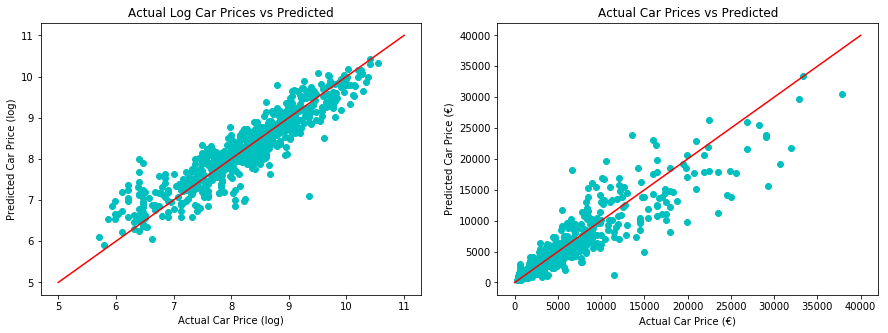

In [141]:
fig = plt.figure(figsize = (15, 5))

#Visualizing predictions versus actuals
y_train_log_predicted = car_ad_model_log.predict(X_norm)

plt.subplot(1, 2, 1)
plt.scatter(y_log, y_train_log_predicted, color = 'c')
plt.plot([5, 11], [5, 11], color='r')
plt.title('Actual Log Car Prices vs Predicted')
plt.ylabel('Predicted Car Price (log)')
plt.xlabel('Actual Car Price (log)');


plt.subplot(1, 2, 2)
plt.scatter(np.exp(y_log), np.exp(y_train_log_predicted), color = 'c')
plt.plot([5, 11], [5, 11], color='r')
plt.plot([0, 40000], [0, 40000], color='r')
plt.title('Actual Car Prices vs Predicted')
plt.ylabel('Predicted Car Price (€)')
plt.xlabel('Actual Car Price (€)');

In [142]:
#Let's look at the coefficients of my model
print(pd.Series(car_ad_model_log_fit.coef_, X_norm.columns))

Year_of_manufacture    1.524366e-01
Engine_Size_l          3.539095e-01
Mileage_km            -7.503041e-07
Fuel_type             -1.410431e-01
Gearbox                1.972689e-01
Is_German              2.966930e-01
Is_French             -2.479964e-01
Is_Japanese            1.422304e-01
dtype: float64


In [143]:
#Let's do some cross-validation
scores_r2_log = cross_val_score(car_ad_model_log, X_norm, y_log, cv = 5, scoring='r2')
print('The r-squared scores of cross validation:', str(scores_r2_log))
print('The mean of r-squared scores is', str(round(scores_r2_log.mean(), 3))+ '.\n')


scores_mse_log = cross_val_score(car_ad_model_log, X_norm, y_log, cv = 5, scoring='neg_mean_squared_error')
print('The mean squared error scores of cross validation:', str(-scores_mse_log))
print('The mean of the mean squared error scores is:', str(round(-scores_mse_log.mean(), 3)), '\n')
print("On average, I'm missing the price by "+ str(round(np.sqrt(-scores_mse_log.mean()) * 100, 0))+'%\n')


The r-squared scores of cross validation: [0.87329471 0.81038395 0.85456457 0.82060978 0.83202652]
The mean of r-squared scores is 0.838.

The mean squared error scores of cross validation: [0.13341574 0.16695236 0.14164915 0.15867354 0.12613615]
The mean of the mean squared error scores is: 0.145 

On average, I'm missing the price by 38.0%



In [144]:
kf = KFold(n = len(X_norm), n_folds = 5, shuffle = True, random_state = 42)

In [145]:
from sklearn.metrics import r2_score

error_scores = []
r2_scores = []
for train, test in kf:
    X_train = X_norm.iloc[train]
    y_train = y_log.iloc[train]
    X_test = X_norm.iloc[test]
    y_test = y_log.iloc[test]
    car_ad_model_log.fit(X_train, y_train)
    y_test_predict = car_ad_model_log.predict(X_test)
    score = mean_squared_error(np.exp(y_test_predict), np.exp(y_test))
    error = np.sqrt(score)
    error_scores.append(error)
    r2 = r2_score(np.exp(y_test_predict), np.exp(y_test))
    r2_scores.append(r2)
    
print(np.mean(error_scores))
print(np.mean(r2_scores))

2446.795072123289
0.7668049653707932


   test_score  train_score  train_size
0    0.808445     0.873364          50
1    0.835998     0.862559         163
2    0.836693     0.850529         277
3    0.836974     0.847226         390
4    0.837288     0.843811         504 



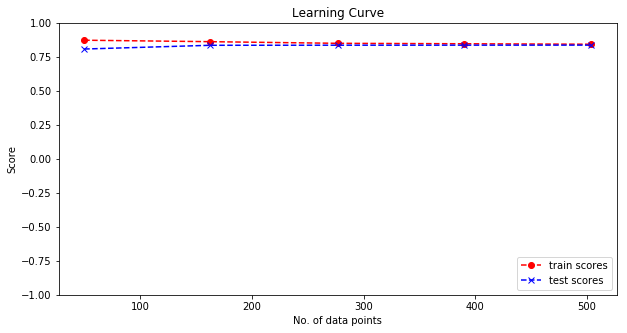

In [146]:
plt.figure(figsize=(10, 5))

scores = cross_val_score(car_ad_model_log_fit, X_all_train, y_log, cv=10, scoring='r2')
mse_scores = cross_val_score(car_ad_model_log_fit, X_all_train, y_log, cv=10, scoring='neg_mean_squared_error')
mean_mse_score = -np.mean(mse_scores)

train_sizes, train_scores, test_scores = learning_curve(car_ad_model_log_fit, X_all_train, y_log, cv=4)
ave_train_scores = train_scores.mean(axis=1)
ave_test_scores = test_scores.mean(axis=1)

learn_df = pd.DataFrame({
    'train_size': train_sizes,
    'train_score': ave_train_scores,
    'test_score': ave_test_scores
})
print(learn_df, '\n')

plt.plot(learn_df['train_size'], learn_df['train_score'], 'r--o', label='train scores')
plt.plot(learn_df['train_size'], learn_df['test_score'], 'b--x', label='test scores')
plt.title('Learning Curve')
plt.xlabel('No. of data points')
plt.ylabel('Score')
plt.legend(loc='lower right')
plt.ylim(-1,1);

**Let's examine the residuals, shall we?**

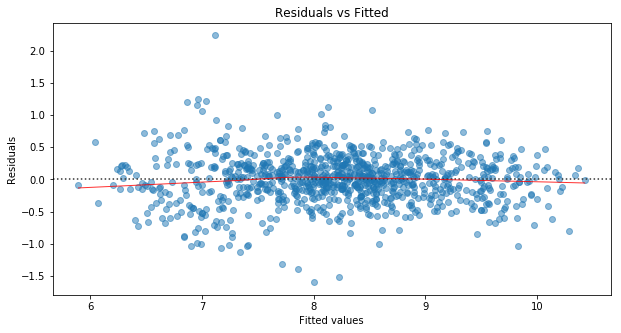

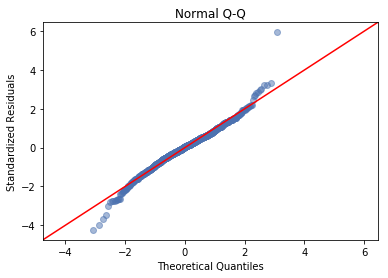

In [147]:
# Use diagnostic_plots python file to plot Year of manufacture results
diagnostic_plots(clean_car_ad_dataset[['Year_of_manufacture', 'Engine_Size_l', 'Mileage_km', 'Fuel_type', 'Gearbox',
                                       'Is_German', 'Is_French', 'Is_Japanese']], np.log(clean_car_ad_dataset['Price']))

In [148]:
#The moment of Truth!
#Model with no transformations
car_ad_model_fit = car_ad_model.fit(X_all_train, y_all_train)
print('The score on the training data', str(car_ad_model_fit.score(X_all_train, y_all_train)))
print('The score on the testing data', str(car_ad_model_fit.score(X_all_test, y_all_test)))

The score on the training data 0.6776585940742712
The score on the testing data 0.6353934693094259


**Let's go crazy!**

In [149]:
#Model trained on log prices
car_ad_model_log_fit = car_ad_model_log.fit(X_all_train, np.log(y_all_train))
print('The score on the training data', str(car_ad_model_log.score(X_all_train, np.log(y_all_train))))
print('The score on the testing data', str(car_ad_model_log.score(X_all_test, np.log(y_all_test))))

The score on the training data 0.8432673333393617
The score on the testing data 0.8484961916950506


### What about Regularization?

In [150]:
from sklearn.model_selection import train_test_split, GridSearchCV
#from sklearn.cross_validation import train_test_split

from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge
from sklearn.preprocessing import StandardScaler

#Let's make a Lasso model
lasso = Lasso()
ssX = StandardScaler()
X_train_scaled = ssX.fit_transform(X_all_train)

params = {
    'alpha': [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1.0, 10, 100],
    'max_iter': [1000, 2000, 4000]
}

grid1 = GridSearchCV(lasso, param_grid = params, cv=8, scoring='neg_mean_squared_error')
grid1.fit(X_train_scaled, y_log)

grid2 = GridSearchCV(lasso, param_grid = params, cv=8, scoring='r2')
grid2.fit(X_train_scaled, y_log);

In [151]:
grid1_alpha = grid1.best_params_['alpha']
grid2_alpha = grid2.best_params_['alpha']

# What was the best score on the hold out set?# What w 
print('Using Lasso best MSE was obtained with alpha =', str(grid1_alpha), 'at', str(-grid1.best_score_))
print('Using Lasso best r-squared was obtained with alpha =', str(grid2_alpha), 'at', str(grid2.best_score_))

Using Lasso best MSE was obtained with alpha = 0.0001 at 0.14636027334050666
Using Lasso best r-squared was obtained with alpha = 0.0001 at 0.8348702867170602


In [152]:
from sklearn.model_selection import train_test_split, GridSearchCV
#from sklearn.cross_validation import train_test_split

from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge
from sklearn.preprocessing import StandardScaler

#Let's make a Ridge model
ridge = Ridge()
ssX = StandardScaler()
X_train_scaled = ssX.fit_transform(X_all_train)

params = {
    'alpha': [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1.0, 10, 100],
    'max_iter': [1000, 2000, 4000]
}

grid3 = GridSearchCV(ridge, param_grid = params, cv=8, scoring='neg_mean_squared_error')
grid3.fit(X_train_scaled, y_log)

grid4 = GridSearchCV(ridge, param_grid = params, cv=8, scoring='r2')
grid4.fit(X_train_scaled, y_log);

In [153]:
grid3_alpha = grid1.best_params_['alpha']
grid4_alpha = grid2.best_params_['alpha']

# What was the best score on the hold out set?# What w 
print('Best MSE was obtained with alpha =', str(grid3_alpha), 'at', str(-grid3.best_score_))
print('Best r-squared was obtained with alpha =', str(grid4_alpha), 'at', str(grid4.best_score_))

Best MSE was obtained with alpha = 0.0001 at 0.14634680193319247
Best r-squared was obtained with alpha = 0.0001 at 0.8348930524112251


> **Regularization is sooo overrated!**

## Finally, can I do better using more sophisticated models?

In [154]:
from sklearn import linear_model,ensemble, tree, model_selection, datasets
models = {}
parameters = {}

models['linear_model'] = linear_model.LinearRegression()
models['randomForest'] = ensemble.RandomForestRegressor()
models['gradboostedTrees'] = ensemble.GradientBoostingRegressor()

for name,model in models.items():
    scores = model_selection.cross_val_score(model, X_all_train, y_all_train, n_jobs=1)
    print('Model: '+name)
    print("Score: " + str(np.mean(scores)))
    print()

Model: linear_model
Score: 0.6652128805947913

Model: randomForest
Score: 0.7784016428564704

Model: gradboostedTrees
Score: 0.8272854239634944



> **The conclusion is that, given my transformed dataset, Gradient Boosting Regressor would give the best results**